<a href="https://colab.research.google.com/github/AndreassOlsson/HuggingFace/blob/main/sentences_comparison_snli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyse the contents of two sentences (SNLI dataset)



# Downloading, unzipping and saving data as dataframes

In [ ]:
from zipfile import ZipFile

file_name = "drive/MyDrive/Andreas Olsson/Huggingface/hf3_files-and-model-weights/snli_1.0.zip"
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

In [ ]:
import json
import pandas as pd

# TRAIN DATA
with open ('/content/snli_1.0/snli_1.0_train.jsonl', 'r') as json_lines:
  reg_json = json_lines.read().splitlines() 

  df_intermediate = pd.DataFrame(reg_json)
  df_intermediate.columns = ['json_element']

  df_intermediate['json_element'].apply(json.loads)

  tr = pd.json_normalize(df_intermediate['json_element'].apply(json.loads))

# DEV DATA
with open ('/content/snli_1.0/snli_1.0_dev.jsonl', 'r') as json_lines:
  reg_json = json_lines.read().splitlines() 

  df_intermediate = pd.DataFrame(reg_json)
  df_intermediate.columns = ['json_element']

  df_intermediate['json_element'].apply(json.loads)

  dev = pd.json_normalize(df_intermediate['json_element'].apply(json.loads))

# TEST DATA
with open ('/content/snli_1.0/snli_1.0_test.jsonl', 'r') as json_lines:
  reg_json = json_lines.read().splitlines() 

  df_intermediate = pd.DataFrame(reg_json)
  df_intermediate.columns = ['json_element']

  df_intermediate['json_element'].apply(json.loads)

  ts = pd.json_normalize(df_intermediate['json_element'].apply(json.loads))


# Choosing a suitable pre-trained model

BERT will be chosen as the pre-trained model

Pros:

*   More suitable for sequence classification (compared to GPT-2 which is more optimized for text generation)
*   Much better model performance over legacy methods
*   Ability to process larger amounts of text and language
*   Suitable for pre-training

Cons:


*   It is a large and computationally expensive model
*   Slow to train

# Analysing and transforming the data

## Tidy up dataframe

In [ ]:
# Drop unnecssary colunms
tr = tr[['gold_label', 'sentence1', 'sentence2']]
dev = dev[['gold_label', 'sentence1', 'sentence2']]
ts = ts[['gold_label', 'sentence1', 'sentence2']]

In [ ]:
tr.sample(3)

,gold_label,sentence1,sentence2
97791,contradiction,A young girl wearing a pink tutu.,A young man wearing a pink tutu.
416581,neutral,Many people out enjoying themselves and admiri...,The people are looking at motorcycles from the...
327962,neutral,A man is doing tricks on a bicycle on ramps in...,The man is being paid for the tricks.


In [ ]:
tr.groupby('gold_label').count()

,sentence1,sentence2
gold_label,,
-,785,785
contradiction,183187,183187
entailment,183416,183416
neutral,182764,182764


In [ ]:
# Drop examples without gold_label
tr = tr[tr['gold_label'] != '-']
dev = dev[dev['gold_label'] != '-']
ts = ts[ts['gold_label'] != '-']

## Analyse vocabulary of sentences & create updated test+dev dataset

In [ ]:
# Compare the lengths of sentences in the test and dev set
import matplotlib.pyplot as plt

dev['len1'] = dev['sentence1'].apply(len)
dev['len2'] = dev['sentence2'].apply(len)
dev['l1-l2'] = dev['len1'] - dev['len2']

ts['len1'] = ts['sentence1'].apply(len)
ts['len2'] = ts['sentence2'].apply(len)
ts['l1-l2'] = ts['len1'] - ts['len2']

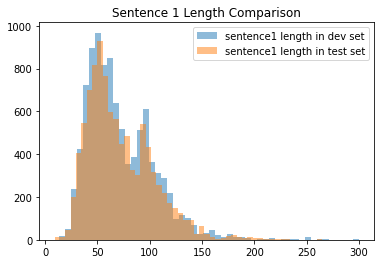

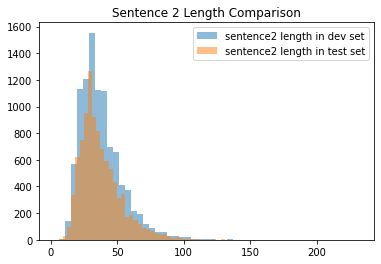

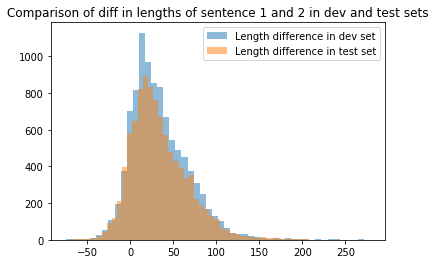

In [ ]:
plt.hist(dev['len1'], bins=50, label="sentence1 length in dev set", alpha=0.5)
plt.hist(ts['len1'], bins=50, label="sentence1 length in test set", alpha=0.5)
plt.title("Sentence 1 Length Comparison")
plt.legend(loc='best')
plt.show()

plt.hist(dev['len2'], bins=50, label="sentence2 length in dev set", alpha=0.5)
plt.hist(ts['len2'], bins=50, label="sentence2 length in test set", alpha=0.5)
plt.title("Sentence 2 Length Comparison")
plt.legend(loc='best')
plt.show()

plt.hist(dev['l1-l2'], bins=50, label="Length difference in dev set", alpha=0.5)
plt.hist(ts['l1-l2'], bins=50, label="Length difference in test set", alpha=0.5)
plt.title("Comparison of diff in lengths of sentence 1 and 2 in dev and test sets")
plt.legend(loc='best')
plt.show()

In [ ]:
# Since the lengths of the sentences are fairly similar, compare the vocabulary used
def unique_words(column):
  ws = list(column.str.split(' ', expand=True).stack().unique())
  ws = [w.strip('.,;()[]') for w in ws]
  return ws

def common_words(l1, l2):
  return [w for w in l1 if w in l2]

def analyse_vocab(dev, ts):
  d1 = unique_words(dev['sentence1'])
  d2 = unique_words(dev['sentence2'])
  d = d1 + d2
  d = list(set(d))

  t1 = unique_words(ts['sentence1'])
  t2 = unique_words(ts['sentence2'])
  t = t1 + t2
  t = list(set(t))

  print('% Words in common in both dev and test set', str(len(common_words(d, t))/len(t)))

< 60% words in common is not ideal and can lead to poor generalization. To solve this, either:

*   Shuffle test and dev set randomly, into two equal halves
*   Randomly split the test set into equal halves using one half as dev set and the other as test set

Since the test set is large enough, the second option is chosen since the first might distort the representativeness of test data

In [ ]:
import numpy as np
np.random.seed(42)

mask = np.random.rand(len(ts)) < 0.5

print('OLD')
old_dev = dev
old_ts = ts
analyse_vocab(old_dev, old_ts)

# Remove temporary columns len1, len2 etc.
dev = dev[['gold_label','sentence1','sentence2']]
ts = ts[['gold_label','sentence1','sentence2']]

print('\nNEW')
dev = ts[mask]
ts = ts[~mask]
analyse_vocab(dev, ts)

OLD
% Words in common in both dev and test set 0.5713884204609331

NEW
% Words in common in both dev and test set 0.7753661549320628


## Encode labels, transform dataframe to dataset & tokenize sentences

BERT encoder expects three lists as inputs for each sentence:

*   input_ids, which are indices corresponding to each token in the sentence
*   attention_mask, which indicates whether a token should be attended to or not
*   token_type_ids, which identifies which sequence a token belongs to when there is more than one sequence

HuggingFace has pretrained tokenizers, designed for various models (such as the BERT model, both cased and uncased) which returns all of the above

In [ ]:
!pip install transformers datasets

In [ ]:
# Encode str gold_label to int labels
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

tr['labels'] = encoder.fit_transform(tr['gold_label'])
dev['labels'] = encoder.fit_transform(dev['gold_label'])
ts['labels'] = encoder.fit_transform(ts['gold_label'])

In [ ]:
# Convert to huggingface Dataset
from datasets import Dataset

tr_dataset = Dataset.from_pandas(tr)
dev_dataset = Dataset.from_pandas(dev)
ts_dataset = Dataset.from_pandas(ts)

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

def tokenize_function(example):
  return tokenizer(example['sentence1'],example['sentence2'], padding='max_length', truncation=False)

tr_tok = tr_dataset.map(tokenize_function, batched=True)
dev_tok = dev_dataset.map(tokenize_function, batched=True)
ts_tok = ts_dataset.map(tokenize_function, batched=True)

  0%|          | 0/550 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

In [ ]:
tr_tok.save_to_disk('drive/MyDrive/Andreas Olsson/Huggingface/hf3_files-and-model-weights/tr')
dev_tok.save_to_disk('drive/MyDrive/Andreas Olsson/Huggingface/hf3_files-and-model-weights/dev')
ts_tok.save_to_disk('drive/MyDrive/Andreas Olsson/Huggingface/hf3_files-and-model-weights/ts')

# Transforming tokenized datasets to TF format, loading, compiling and training model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install transformers datasets

In [ ]:
# Load tokenized datasets
from datasets import load_from_disk

tr_tok = load_from_disk('drive/MyDrive/Andreas Olsson/Huggingface/hf3_files-and-model-weights/tr')
dev_tok = load_from_disk('drive/MyDrive/Andreas Olsson/Huggingface/hf3_files-and-model-weights/dev')
ts_tok = load_from_disk('drive/MyDrive/Andreas Olsson/Huggingface/hf3_files-and-model-weights/ts')

In [ ]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator(return_tensors="tf")

In [ ]:
tr_small = tr_tok.shuffle(seed=42).select(range(20000))
dev_small= dev_tok.shuffle(seed=42).select(range(4000))

tr_tfSet = tr_small.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

dev_tfSet = dev_small.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

In [ ]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

In [ ]:
# Save model's weights after each epoch
import os
checkpoint_path = "drive/MyDrive/Andreas Olsson/Huggingface/hf3_files-and-model-weights/"

checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback
model.fit(tr_tfSet, validation_data=dev_tfSet, epochs=3, callbacks=[cp_callback])  # Pass callback to training

Epoch 1/3
2500/2500 [==============================] - ETA: 0s - loss: 0.7075 - sparse_categorical_accuracy: 0.6988
Epoch 1: saving model to drive/MyDrive/Andreas Olsson/Huggingface/hf3_files-and-model-weights/
2500/2500 [==============================] - 2582s 1s/step - loss: 0.7075 - sparse_categorical_accuracy: 0.6988 - val_loss: 0.5753 - val_sparse_categorical_accuracy: 0.7778
Epoch 2/3
2500/2500 [==============================] - ETA: 0s - loss: 0.4818 - sparse_categorical_accuracy: 0.8187
Epoch 2: saving model to drive/MyDrive/Andreas Olsson/Huggingface/hf3_files-and-model-weights/
2500/2500 [==============================] - 2557s 1s/step - loss: 0.4818 - sparse_categorical_accuracy: 0.8187 - val_loss: 0.5607 - val_sparse_categorical_accuracy: 0.7832
Epoch 3/3
2500/2500 [==============================] - ETA: 0s - loss: 0.3587 - sparse_categorical_accuracy: 0.8690
Epoch 3: saving model to drive/MyDrive/Andreas Olsson/Huggingface/hf3_files-and-model-weights/
2500/2500 [==========